# Example: The Pricing of American Style Options Contracts
The premium of an American-style contract is _greater than or equal to_ the expected value of the discounted future payoff:

$$
\begin{equation}
\mathcal{P}_{\star}(K,T, S(0)) \geq \mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{\star}}(K,S(T))\Bigr)
\end{equation}
$$

The key difference between European and American-style option contracts is that early exercise is allowed for American-style contracts. Thus, the contract seller may demand a premium that is _greater than the European contract_ because of the possibility of early exercise. For American-style contracts, the buyer can exercise between $0\rightarrow{T}$ at any time.

## Learning objectives
In this example, we'll use the binomial lattice approximation of the share price over the time interval $0\rightarrow{T}$ in combination with a dynamic programming to compute the contract premium for American style contracts. In particular, we will:

* Fill me in

## Setup

In [1]:
include("Include.jl")

  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1/Manifest.toml`


loadoptionsdata (generic function with 1 method)

In [2]:
options_dataset = loadoptionsdata();

## Objectives
A binomial lattice model assumes that each discrete time increment, the state of the system, e.g., the share price of equity, the spot rate, etc., can either increase by a factor $u$ with probability $p$ or decrease by a factor $d$ with probability $(1-p)$. Different models can be developed for the specific values of the tuple $(u,d,p)$.

### Objective 1: Pricing American options contracts using the CRR model

One particular model is the Cox, Ross, and Rubinstein (CRR) model:

* [Cox, J. C.; Ross, S. A.; Rubinstein, M. (1979). "Option pricing: A simplified approach". Journal of Financial Economics. 7 (3): 229. CiteSeerX 10.1.1.379.7582. doi:10.1016/0304-405X(79)90015-1](https://www.sciencedirect.com/science/article/pii/0304405X79900151?via%3Dihub)

The [CRR binomial lattice model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) was initially developed for options pricing in 1979. However, one of the critical aspects of estimating an option’s price is calculating the underlying asset’s share price. In the [CRR model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) model, the `up` and `down` moves are symmetric:

$$ud = 1$$

where the magnitude of an `up` move $u$ is given by:

$$u = \exp(\sigma\sqrt{\Delta{T}})$$

The quantity $\sigma$ denotes a _volatility parameter_, and $\Delta{T}$ represents the time step. The probability $p$ of an `up` move in a [CRR model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) is given by:

$$p = \frac{\exp(\bar{r}\Delta{T}) - d}{u - d}$$

where $\bar{r}$ denotes a _return parameter_. In the [CRR model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) model paradigm, the return parameter $\mu$ and the volatility parameter $\sigma$ take on common values:
* The return parameter is a _risk-free_ rate of return; the _risk-free_ rate $\bar{r}$ can be approximated by the [yield on T = 10-year United States Treasury debt security](https://ycharts.com/indicators/10_year_treasury_rate). 
* The volatility parameter $\sigma$ is the [implied volatility](https://www.investopedia.com/terms/i/iv.asp); the implied volatility is the market's view of the likelihood of changes in a given security's price.

#### Implementation
Let's use the `CRR model` to simulate the premium of American-style options contracts as a function of the strike price `K`. We downloaded the options chain for [Advanced Micro Devices (AMD)](https://en.wikipedia.org/wiki/AMD) from [barchart.com](https://www.barchart.com). For this set of values, the share price of `AMD` was $S_{\circ}$ = 117.50 USD/share, and the average implied volatility for `AMD` options with `DTE = 31 days` is `IV = 51.75%`. Load the options data using using the `loadoptionsdata(...)` function and store in the `options_dataset` variable:

In [11]:
options_dataset = loadoptionsdata();

Next, let's set constant values for the contracts (these values, with the exception of `IV` are the same for each strike price `K`). The time will be calendar days `Δt = 1/365`, the initial share price `Sₒ` is 117.50 USD/share, the days to expiration or `DTE` is `31` days, the annual risk-free rate is `r̄ = 0.0418` and the (average) implied volatility `IV = 51.75%`:

In [4]:
Δt, Sₒ, r̄, IV = (1.0/365.0), 117.50, 0.0418, 0.5175;
DTE = 31.0*Δt;
start_strike = 40.0;
stop_strike = 200.0;
KA = range(start_strike, stop = stop_strike, step=1) |> collect;

Let's create instances of the `MyAmericanPutContractModel` and `MyAmericanCallContractModel` models which holds the data for the contract information using the `build(...)` method. We store these instances in the `american_put_contract_model` and the `american_call_contract_model` variables:

In [5]:
american_put_contract_model = build(MyAmericanPutContractModel, (
        K = 0.0, IV = IV, DTE = DTE, sense = 1));

american_call_contract_model = build(MyAmericanCallContractModel, (
        K = 0.0, IV = IV, DTE = DTE, sense = 1));

To start this calculation, we first build an instance of the `MyAdjacencyBasedCRREquityPriceTree` type which holds the parameters and data for the binomial price tree using the `build(...)` function. We store this in the `treemodel` variable. We calculate the premium for various strike prices, ranging from `K=60` to `K=160`, and record the estimated premium in the `df_CRR_put_simulation` DataFrame. For each strike price:

* We first check if there is an existing `IV` value in the dataset. If there is, we use that `IV` value. Otherwise, we use the average value for the implied volatility, `IV = 0.5175`. 
* Then, we use the `build(…)` method to create an instance of the `MyAmericanPutContractModel` type, which contains information about the contract. This is stored in the `put_contract_model` variable. Finally, we calculate the premium for this contract using the `premium(…)` function.

In [6]:
KA = range(start_strike, stop = stop_strike, step=1) |> collect;
put_dataset = filter([:Type, :Strike] => (x,y)-> x == "Put" && y ∈ KA, options_dataset);
df_CRR_put_simulation = DataFrame()
for value ∈ KA
    
    
    # compute the IV - use average IV is not in dataset
    tmp = put_dataset[put_dataset.Strike .== value, :IV]
    IV_value = IV;
    if (isempty(tmp) == false)
        IV_value = first(tmp);
    end
    
    # build the tree -
    treemodel = build(MyAdjacencyBasedCRREquityPriceTree, μ = r̄, h = 365, 
        T = DTE, σ = first(IV_value), Sₒ = Sₒ);
    
    american_put_contract_model.K = value;   
    price_value = premium(american_put_contract_model, treemodel)

    # store the results
    results_tuple = (
        K = value,
        premium = price_value,
        Type = "Put"
    );
    push!(df_CRR_put_simulation, results_tuple);
end

We calculate the premium for various strike prices, ranging from `K=60` to `K=160`, and record the estimated premium in the `df_CRR_call_simulation` DataFrame. For each strike price:

* We first check if there is an existing `IV` value in the dataset. If there is, we use that `IV` value. Otherwise, we use the average value for the implied volatility, `IV = 0.5175`. 
* Then, we use the `build(…)` method to create an instance of the `MyAmericanCallContractModel` type, which contains information about the contract. This is stored in the `call_contract_model` variable. Finally, we calculate the premium for this contract using the `premium(…)` function.

In [7]:
KA = range(start_strike, stop = stop_strike, step=1) |> collect;
call_dataset = filter([:Type, :Strike] => (x,y)-> x == "Call" && y ∈ KA, options_dataset);
df_CRR_call_simulation = DataFrame()
for value ∈ KA
    
    # compute the IV - use average IV is not in dataset
    tmp = call_dataset[call_dataset.Strike .== value, :IV]
    IV_value = IV;
    if (isempty(tmp) == false)
        IV_value = first(tmp);
    end
    
    # build the tree -
    treemodel = build(MyAdjacencyBasedCRREquityPriceTree, μ = r̄, h = 365, 
        T = DTE, σ = first(IV_value), Sₒ = Sₒ);
    
    american_call_contract_model.K = value;   
    price_value = premium(american_call_contract_model, treemodel)

    # store the results
    results_tuple = (
        K = value,
        premium = price_value,
        Type = "Call"
    );
    push!(df_CRR_call_simulation, results_tuple);
end

#### Visualize
Let's plot the strike price `K` on the horizontal axis and the estimated premium on the vertical axis. 
* The LSM option price simulation fails to capture the prices of `put` options that are `near the money`, i.e., when $S_{\circ}\simeq{K}$, but does capture the prices for `in the money`, i.e., $S_{\circ} \ll {K}$ and `out of the money`, i.e., $S_{\circ}\gg{K}$ `put` contracts:

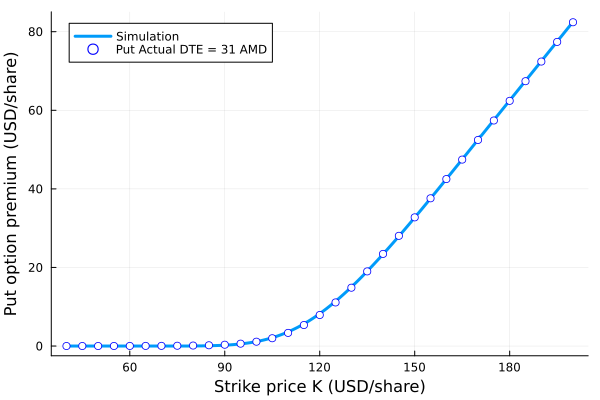

In [19]:
plot(df_CRR_put_simulation[:,1],df_CRR_put_simulation[:,2], lw=3, label="Simulation")
scatter!(put_dataset[:,:Strike], put_dataset[:,:Ask],label="Put Actual DTE = 31 AMD", mc=:white, msc=:blue)
xlabel!("Strike price K (USD/share)", fontsize=18)
ylabel!("Put option premium (USD/share)", fontsize=18) 

# plot!(df_CRR_call_simulation[:,1],df_CRR_call_simulation[:,2], lw=3, label="Simulation")
# scatter!(call_dataset[:,:Strike], call_dataset[:,:Ask],label="Call Actual DTE = 31 AMD", mc=:white, msc=:blue)
# xlabel!("Strike price K (USD/share)", fontsize=18)
# ylabel!("Put option premium (USD/share)", fontsize=18) 

### Objective 2: Time and Volatility Dependence of American Option Contract Pricing
Fill me in.

In [30]:
number_of_divisions = 5;
design_array = Array{Float64,2}(undef, number_of_divisions, number_of_divisions);
DTE_array = range(0.8*DTE,stop = 1.2*DTE, length = number_of_divisions) |> collect;
IV_array = range(0.8*IV, stop = 1.2*IV, length = number_of_divisions) |> collect;

In [33]:
american_put_contract_model.K = 120.0;
treemodel = build(MyAdjacencyBasedCRREquityPriceTree, μ = r̄, h = 365, 
            T = DTE, σ = IV, Sₒ = Sₒ);
baseprice = premium(american_put_contract_model, treemodel)

for i ∈ eachindex(DTE_array)
    
    DTE_value = DTE_array[i];
    
    for j ∈ eachindex(IV_array)
        IV_value = IV_array[j];
        
        treemodel = build(MyAdjacencyBasedCRREquityPriceTree, μ = r̄, h = 365, 
            T = DTE_value, σ = IV_value, Sₒ = Sₒ);
        
        price_value = premium(american_put_contract_model, treemodel)
        design_array[i,j] = log(price_value/baseprice);
    end
end

design_array

5×5 Matrix{Float64}:
 -0.271103  -0.176296   -0.0896996  -0.00891392  0.0658022
 -0.227085  -0.13096    -0.0425262   0.0391499   0.114611
 -0.187317  -0.0899002   0.0         0.0824414   0.158548
 -0.151039  -0.052002    0.0387146   0.121829    0.198504
 -0.117683  -0.0171909   0.0742478   0.157961    0.235141